In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

In [2]:
T = 101
theta = np.linspace(0, (T-1)*0.1, T)
x_seq = pd.read_csv('duffing.csv', header=None).values.T.astype(np.float32)
# theta = np.linspace(0, 4 * np.pi, T)
# x_seq = np.stack([theta * np.cos(theta), theta * np.sin(theta)], axis=1).astype(np.float32)
# theta = np.linspace(0, 2 * np.pi, T)
# x_seq = np.stack([np.cos(theta), np.sin(theta)], axis=1).astype(np.float32)

x_t = torch.tensor(x_seq[:-1])
x_tp1 = torch.tensor(x_seq[1:])

In [3]:
class KoopmanAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 2)
        )
        self.K = nn.Parameter(torch.randn(2, 2))  # Koopman operator K

    def forward(self, x):
        z = self.encoder(x)           # z_t
        z_next_pred = z @ self.K.T   # z_{t+1} ≈ K z_t
        x_recon = self.decoder(z)    
        return z, z_next_pred, x_recon

In [ ]:
best_loss = float('inf')
best_model_state = None

model = KoopmanAutoEncoder()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

num_epochs = 9999
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    z_t, z_tp1_pred, x_recon = model(x_t)
    z_tp1 = model.encoder(x_tp1).detach()

    loss_recon = loss_fn(x_recon, x_t)
    loss_koop = loss_fn(z_tp1_pred, z_tp1)
    loss = loss_recon + loss_koop
    loss.backward()
    optimizer.step()
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_model_state = model.state_dict()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")
        
model.load_state_dict(best_model_state)
model.eval()
print("Loss =", best_loss)

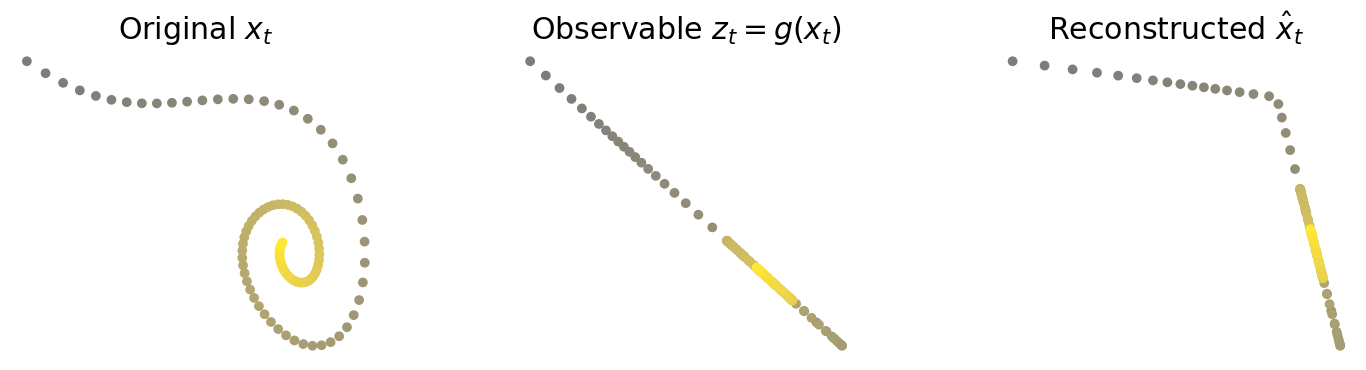

In [6]:
# model.eval()
# with torch.no_grad():
#     z_all, _, x_recon_all = model(torch.tensor(x_seq))

# z_all_np = z_all.numpy()
# x_recon_all_np = x_recon_all.numpy()

default_fontsize = mpl.rcParamsDefault['font.size']
plt.rcParams.update({'font.size': default_fontsize * 1.8})

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
c = theta[:-1]
cividis_cut = ListedColormap(plt.cm.cividis(np.linspace(0.5, 1.0, 256)))

axes[0].scatter(x_seq[:-1, 0], x_seq[:-1, 1], c=c, cmap=cividis_cut)
axes[0].set_title("Original $x_t$", pad=0)

axes[1].scatter(z_all_np[:-1, 0], z_all_np[:-1, 1], c=c, cmap=cividis_cut)
axes[1].set_title("Observable $z_t = g(x_t)$", pad=0)

axes[2].scatter(x_recon_all_np[:-1, 0], x_recon_all_np[:-1, 1], c=c, cmap=cividis_cut)
axes[2].set_title("Reconstructed $\\hat{x}_t$", pad=0)

for ax in axes:
    ax.set_aspect('equal')
    ax.axis('off')

plt.tight_layout()
# plt.savefig("challenge1.svg", format='svg', bbox_inches='tight')
plt.show()

In [8]:
np.save('z_all_np.npy', z_all_np)
np.save('x_recon_all_np.npy', x_recon_all_np)

In [4]:
z_all_np = np.load('z_all_np.npy')
x_recon_all_np = np.load('x_recon_all_np.npy')

/tmp/ipykernel_1042540/4034047093.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


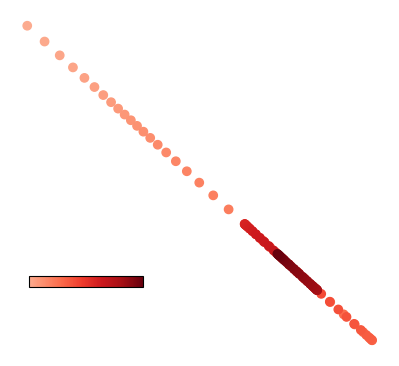

In [23]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

c = theta[:-1]

fig1, ax1 = plt.subplots(figsize=(5, 4))
sc1 = ax1.scatter(z_all_np[:-1, 0], z_all_np[:-1, 1], c=c, cmap=reds_cut)
ax1.set_aspect('equal')
ax1.axis('off')

axins1 = inset_axes(ax1,
                    width="30%",    
                    height="3%",    
                    loc='lower left',
                    bbox_to_anchor=(0.05, 0.2, 1, 1), 
                    bbox_transform=ax1.transAxes,
                    borderpad=0)

cbar1 = plt.colorbar(sc1, cax=axins1, orientation='horizontal')
cbar1.ax.tick_params(left=False, right=False, top=False, bottom=False, labelbottom=False)

plt.tight_layout()
plt.savefig("a3.svg", format='svg', bbox_inches=None)
plt.show()

/tmp/ipykernel_1042540/4197759877.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


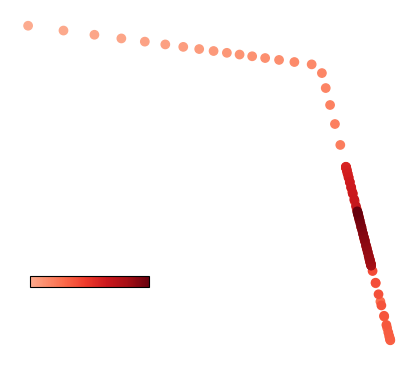

In [24]:
fig2, ax2 = plt.subplots(figsize=(5, 4))
sc2 = ax2.scatter(x_recon_all_np[:-1, 0], x_recon_all_np[:-1, 1], c=c, cmap=reds_cut)
# ax2.set_title("Reconstructed $\\hat{x}_t$", pad=10)
ax2.set_aspect('equal')
ax2.axis('off')

axins2 = inset_axes(ax2, width="30%", height="3%", loc='lower left',
                    bbox_to_anchor=(0.05, 0.2, 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
cbar2 = plt.colorbar(sc2, cax=axins2, orientation='horizontal')
cbar2.ax.tick_params(left=False, right=False, top=False, bottom=False, labelbottom=False)

plt.tight_layout()
plt.savefig("a4.svg", format='svg', bbox_inches=None)
plt.show()